In [1]:
# Import all packages and functions needed for entire analysis
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import scipy as sci
from requests import get
import folium
from geopy.geocoders import ArcGIS
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import pycountry
import re
from scipy.cluster import hierarchy 
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA 
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (12, 12) 
import statsmodels.formula.api as sm

Importing database essentials and cleaning data

In [2]:
# Import CSV Files Extracted from the Earthquake Impact Database
data_2017 = pd.read_csv("2017_raw.csv", encoding = "ISO-8859-1").dropna(axis = 0, how = "all")
data_2018 = pd.read_csv("2018_raw.csv", encoding = "ISO-8859-1").dropna(axis = 0, how = "all")
data_2019 = pd.read_csv("2019_raw.csv", encoding = "ISO-8859-1").dropna(axis = 0, how = "all")
data_2020 = pd.read_csv("2020_raw.csv", encoding = "ISO-8859-1").dropna(axis = 0, how = "all", thresh = 2)

In [3]:
# Clean 2017 Data
data_2017 = data_2017.drop('Depth (km)', axis = 1).drop('Tsunami height', axis = 1)
data_2017 = data_2017.fillna(value = 0).replace("--", "0")
latlong_2017 = [0 for _ in range(0, len(data_2017.index))]
data_2017.insert(loc = 4, column = 'Lat', value = latlong_2017)
data_2017.insert(loc = 5, column = 'Long', value = latlong_2017)
data_2017 = data_2017.rename(columns = {"Impact coefficient (D)" : "Impact value (D)"} )

# Clean 2018 Data
data_2018 = data_2018.drop('Depth (km)', axis = 1).drop('Type', axis = 1).drop('Origin', axis = 1).drop('Tsunami height', axis = 1)
data_2018 = data_2018.fillna(value = 0).replace("--", "0")
latlong_2018 = [0 for _ in range(0, len(data_2018.index))]
data_2018.insert(loc = 4, column = 'Lat', value = latlong_2018)
data_2018.insert(loc = 5, column = 'Long', value = latlong_2018)
data_2018 = data_2018.rename(columns = {"Country (Epicenter)" : "Country", "Region (Epicenter)" : "Region"} )

# Clean 2019 Data
data_2019 = data_2019.drop('Depth (km)', axis = 1).drop('Type', axis = 1).drop('Origin', axis = 1).drop('Tsunami height', axis = 1)
data_2019 = data_2019.fillna(value = 0).replace("--", "0")
data_2019 = data_2019.rename(columns = {"Country (Epicenter)" : "Country", "Region (Epicenter)" : "Region"} )

# Clean 2020 Data
data_2020 = data_2020.drop('Depth (km)', axis = 1).drop('Type', axis = 1).drop('Origin', axis = 1).drop('Tsunami height', axis = 1)
data_2020 = data_2020.fillna(value = 0)
data_2020 = data_2020.rename(columns = {"Epicenter" : "Country", "Region (Epicenter)" : "Region"} )

In [4]:
# Concatenate Dataframes into a Single Dataset
earthquake_data = pd.concat([data_2017, data_2018, data_2019, data_2020], sort = False).reset_index(drop = True)
Database = pd.concat([data_2019, data_2020], sort = False).reset_index(drop = True)

Cleaning and converting data

In [5]:
# Convert "Intensity (MMI / JMA)" Column from Roman Numerals to Integers
earthquake_data['Intensity (MMI / JMA)']=earthquake_data['Intensity (MMI / JMA)'].str.replace('+',' ')
earthquake_data['Intensity (MMI / JMA)']=earthquake_data['Intensity (MMI / JMA)'].str.replace('-',' ')
earthquake_data['Intensity (MMI / JMA)']=earthquake_data['Intensity (MMI / JMA)'].str.replace('JMA',' ')
earthquake_data['Intensity (MMI / JMA)']=earthquake_data['Intensity (MMI / JMA)'].str.replace('/ 7',' ')
earthquake_data['Intensity (MMI / JMA)']=earthquake_data['Intensity (MMI / JMA)'].str.replace('Shindo ','')

Database['Intensity (MMI / JMA)']=Database['Intensity (MMI / JMA)'].str.replace('+',' ')
Database['Intensity (MMI / JMA)']=Database['Intensity (MMI / JMA)'].str.replace('-',' ')
Database['Intensity (MMI / JMA)']=Database['Intensity (MMI / JMA)'].str.replace('JMA',' ')
Database['Intensity (MMI / JMA)']=Database['Intensity (MMI / JMA)'].str.replace('/ 7',' ')
Database['Intensity (MMI / JMA)']=Database['Intensity (MMI / JMA)'].str.replace('Shindo ','')

def roman_to_number(num):
    rom_val = {'I': 1, 'V': 5, 'X': 10, 'L':50 , 'C':100, 'D':500, 'M':1000}
    res=0
    i=0
    while i<len(num):
        s1=num[i]
        num1=rom_val[s1]
        if i+1<len(num):
            s2=num[i+1]
            num2=rom_val[s2]
            if num2<=num1:
                res=res+num1
                i+=1
            else:
                res=res+num2-num1
                i+=2
        else:
            res=res+num1
            i+=1
    return(res)
        
    
           
def change(num):
    if type(num)==str:
        if len(num)>4:
            tip=num[0:len(num)//2].strip()
        else:
            tip=num.strip()
        try:
            return(int(tip))
        except:
            return(roman_to_number(tip))
    else:
        return(num)
earthquake_data['Intensity (MMI / JMA)']=[change(chest) for chest in earthquake_data['Intensity (MMI / JMA)']]
Database['Intensity (MMI / JMA)']=[change(chest) for chest in Database['Intensity (MMI / JMA)']]

In [6]:
earthquake_data

,Date (UTC),Country,Region,Magnitude,Lat,Long,Intensity (MMI / JMA),Fatalities,Injuries,displaced,Impact value (D),buildings damaged,buildings destroyed
0,1/2/2017,Italy,Umbria,4.1,0.00,0.00,5.0,0.0,0.0,30.0,0.194401,0.0,0.0
1,1/3/2017,India,Tripura,5.5,0.00,0.00,NaN,3.0,49.0,600.0,1.668774,1456.0,166.0
2,1/3/2017,Brazil,Maranhao,4.6,0.00,0.00,NaN,0.0,0.0,0.0,0.752967,500.0,0.0
3,1/3/2017,Fiji,Western Division (OS),7.2,0.00,0.00,4.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,1/6/2017,Iran,Fars,5.1,0.00,0.00,NaN,4.0,4.0,905.0,1.447852,400.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
977,3/13/2020,India,Kerala,2.8,9.79,76.88,NaN,0.0,0.0,0.0,0.038254,10.0,0.0
978,3/13/2020,Tanzania,Tanga,4.8,-4.90,38.55,NaN,0.0,0.0,0.0,0.007925,2.0,0.0
979,3/14/2020,Iran,Qom,4.0,34.56,50.72,NaN,0.0,0.0,0.0,0.038254,10.0,0.0
980,3/15/2020,Iran,Hormozgan,5.4,27.20,55.32,NaN,0.0,2.0,0.0,0.235972,20.0,1.0


Database of current earthquakes across the globe

In [7]:
#Scrape Socioeconomic Information
url = 'https://www.worldometers.info/gdp/gdp-by-country/'
response=get(url)
soup=BeautifulSoup(response.text,'html.parser')
Head=soup.find('thead')
H=Head.find_all('th')
Table=soup.find('tbody')
T=Table.find_all('tr')
columns=[col for col in T[0]]
Beep=[T[i] for i in range(0,len(T))]
headers=[i.get_text() for i in H]

tipping=[]
for col in columns:
    if col==' ':
        pass
    else:
        tipping.append(col.get_text())
tip=[]
for i in range(0,len(T)):
    clip=[]
    columns=[col for col in T[i]]
    for col in columns:
        if col==' ':
            pass
        else:
            clip.append(col.get_text())
    tip.append(clip)
gdp=pd.DataFrame(tip,columns=headers)

#cleaning GDP nominal
gdp['GDP (nominal, 2017) ']=gdp['GDP (nominal, 2017) '].str.replace('$',' ')
gdp['GDP (nominal, 2017) ']=gdp['GDP (nominal, 2017) '].str.replace(',','').astype(float)
gdp['GDP (nominal, 2017) ']=pd.to_numeric(gdp['GDP (nominal, 2017) '] )
gdp.rename(columns={'GDP (nominal, 2017) ':'GDP($)'}, inplace=True)

#Cleanng GDP abbrev
gdp['GDP (abbrev.)']=gdp['GDP (abbrev.)'].str.replace('$',' ')
def money(num,part):
    if part=='trillion':
        num=num*1000000000000
    elif part=='billion':
        num=num*1000000000
    else:
        num=num*1000000
    return(num)

def marker(plop):
    mak=len(plop)//2
    num=plop[0:mak]
    word=plop[mak:len(plop)]
    if word=='illion' or word=='rillion' :
        num=float(plop[0:mak-1])
        word=plop[mak-1:len(plop)]
        return(money(num,word))
    else:
        return(money(float(num),word))
gdp['GDP (abbrev.)']=[marker(i) for i in gdp['GDP (abbrev.)']]
gdp.rename(columns={'GDP (abbrev.)':'GDP (abbrev.)($)'}, inplace=True)

#clean growth
gdp['GDP  growth']=gdp['GDP  growth'].str.replace('%','').astype(float).divide(100)
gdp.rename(columns={'GDP  growth':'GDP  growth(%)'}, inplace=True)
#clean population
gdp['Population (2017) ']=gdp['Population (2017) '].str.replace(',','').astype(int)
gdp.rename(columns={'Population (2017) ':'Population'}, inplace=True)
#clean per capita
gdp['GDP  per capita ']=gdp['GDP  per capita '].str.replace('$',' ').str.replace(',','').astype(int)
gdp.rename(columns={'GDP  per capita ':'GDP  per capita ($)'}, inplace=True)
#share of GDP
gdp['Share of World GDP ']=gdp['Share of World GDP '].str.replace('%','').astype(float).divide(100)
gdp.rename(columns={'Share of World GDP ':'Share of World GDP (%)'}, inplace=True)

In [8]:
gdp

,#,Country,GDP($),GDP (abbrev.)($),GDP growth(%),Population,GDP per capita ($),Share of World GDP (%)
0,1,United States,1.948539e+13,1.948500e+13,0.0227,325084756,59939,0.2408
1,2,China,1.223770e+13,1.223800e+13,0.0690,1421021791,8612,0.1512
2,3,Japan,4.872415e+12,4.872000e+12,0.0171,127502725,38214,0.0602
3,4,Germany,3.693204e+12,3.693000e+12,0.0222,82658409,44680,0.0456
4,5,India,2.650725e+12,2.651000e+12,0.0668,1338676785,1980,0.0328
...,...,...,...,...,...,...,...,...
184,185,Sao Tome & Principe,3.925703e+08,3.930000e+08,0.0387,207089,1896,0.0000
185,186,Palau,2.898235e+08,2.900000e+08,-0.0357,17808,16275,0.0000
186,187,Marshall Islands,2.041734e+08,2.040000e+08,0.0360,58058,3517,0.0000
187,188,Kiribati,1.855725e+08,1.860000e+08,0.0033,114158,1626,0.0000


In [9]:
#Add GDP, Population and GDP per captia to lists for addition to DF

gdp_column = []
pop_column = []
gdp_per_cap_column = []

for i in range(len(earthquake_data)):
    country = earthquake_data.iloc[i, 1]
    if country == "Taiwan":
        gdp_column.append(586104000000)
        pop_column.append(23780452)
        gdp_per_cap_column.append(24828)
    if country == "Venezuela":
        gdp_column.append(70140000000)
        pop_column.append(28887118)
        gdp_per_cap_column.append(2548)
    if country == "Myamnar":
        gdp_column.append(355000000000)
        pop_column.append(53582855)
        gdp_per_cap_column.append(6707)
    if country == "Cayman Islands":
        gdp_column.append(4571000000)
        pop_column.append(68076)
        gdp_per_cap_column.append(70958)
    for j in range(len(gdp)):
        if gdp.iloc[j, 1] == country:
            gdp_column.append(gdp.iloc[j, 2])
            pop_column.append(gdp.iloc[j, 5])
            gdp_per_cap_column.append(gdp.iloc[j, 6])
            break

# Insert columns onto dataframe
earthquake_data.insert(loc = 13, column = 'GDP', value = gdp_column)
earthquake_data.insert(loc = 14, column = 'Population', value = pop_column)
earthquake_data.insert(loc = 15, column = 'GDPPerCapita', value = gdp_per_cap_column)

ValueError: Length of values does not match length of index

In [70]:
# print DataFrame
gdp

,#,Country,GDP($),GDP (abbrev.)($),GDP growth(%),Population,GDP per capita ($),Share of World GDP (%)
0,1,United States,1.948539e+13,1.948500e+13,0.0227,325084756,59939,0.2408
1,2,China,1.223770e+13,1.223800e+13,0.0690,1421021791,8612,0.1512
2,3,Japan,4.872415e+12,4.872000e+12,0.0171,127502725,38214,0.0602
3,4,Germany,3.693204e+12,3.693000e+12,0.0222,82658409,44680,0.0456
4,5,India,2.650725e+12,2.651000e+12,0.0668,1338676785,1980,0.0328
...,...,...,...,...,...,...,...,...
184,185,Sao Tome & Principe,3.925703e+08,3.930000e+08,0.0387,207089,1896,0.0000
185,186,Palau,2.898235e+08,2.900000e+08,-0.0357,17808,16275,0.0000
186,187,Marshall Islands,2.041734e+08,2.040000e+08,0.0360,58058,3517,0.0000
187,188,Kiribati,1.855725e+08,1.860000e+08,0.0033,114158,1626,0.0000


Getting GDP and countries by continent and land area

In [37]:
url1 = 'https://www.worldatlas.com/cntycont.htm'
url2='https://www.nationmaster.com/country-info/stats/Geography/Land-area/Square-miles'

response=get(url1)
soup=BeautifulSoup(response.text,'html.parser')

Tropicanna=soup.find('div',class_="miscTxt")
continents=Tropicanna.find_all('h2')
cont_counts=Tropicanna.find_all('ul')
top=cont_counts[1].find_all('li')
Conts=[con.get_text() for con in continents]
Countries=[]
Continets=[]
for j in range(len(Conts)-2):
    stuff=Conts[j]
    top=cont_counts[j].find_all('li')
    for steel in top:
        Countries.append(steel.get_text())
        Continets.append(stuff)

ConCun=pd.DataFrame(zip(Countries,Continets), columns=['Country','Continents'])
ConCun['Continents']=ConCun['Continents'].str.replace('(','').str.replace(')','').str.replace('\n','')
ConCun['Continents']=[title[0:len(title)-3] for title in ConCun['Continents']]

response1=get(url2)
sauce=BeautifulSoup(response1.text,'html.parser')

tim=sauce.find('tbody')
info=tim.find_all('tr')
country=[]
land=[]
for i in range(0,len(info)):
    test=info[i].find_all('td')
    country.append(test[1].get_text())
    land.append(test[2].get_text().strip())
    
landmass=pd.DataFrame(zip(country,land), columns=['Country','Landarea'])
landmass['Country']=landmass['Country'].str.replace('\n','')

landmass['Landarea']=landmass['Landarea'].str.replace('square miles','').str.replace(',','')
time=[]
for x in landmass['Landarea']:
    if 'million' in x:
        time.append(float(x[0:4])*1000000)
    else:
        time.append(float(x))

        
landmass['Landarea']=time
Information=ConCun.join(landmass.set_index('Country'), on='Country')
earthquake_data=earthquake_data.join(Information.set_index('Country'), on='Country')

In [38]:
# print final DataFrame
earthquake_data

,Date (UTC),Country,Region,Magnitude,Lat,Long,Intensity (MMI / JMA),Fatalities,Injuries,displaced,Impact value (D),buildings damaged,buildings destroyed,Continents,Landarea
0,1/2/2017,Italy,Umbria,4.1,0.00,0.00,5.0,0.0,0.0,30.0,0.194401,0.0,0.0,EUROPE,116346.0
1,1/3/2017,India,Tripura,5.5,0.00,0.00,NaN,3.0,49.0,600.0,1.668774,1456.0,166.0,ASIA,1240000.0
2,1/3/2017,Brazil,Maranhao,4.6,0.00,0.00,NaN,0.0,0.0,0.0,0.752967,500.0,0.0,S. AMERICA,3300000.0
3,1/3/2017,Fiji,Western Division (OS),7.2,0.00,0.00,4.0,0.0,0.0,0.0,0.000000,0.0,0.0,OCEANIA,7095.0
4,1/6/2017,Iran,Fars,5.1,0.00,0.00,NaN,4.0,4.0,905.0,1.447852,400.0,40.0,ASIA,636313.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
977,3/13/2020,India,Kerala,2.8,9.79,76.88,NaN,0.0,0.0,0.0,0.038254,10.0,0.0,ASIA,1240000.0
978,3/13/2020,Tanzania,Tanga,4.8,-4.90,38.55,NaN,0.0,0.0,0.0,0.007925,2.0,0.0,AFRICA,364900.0
979,3/14/2020,Iran,Qom,4.0,34.56,50.72,NaN,0.0,0.0,0.0,0.038254,10.0,0.0,ASIA,636313.0
980,3/15/2020,Iran,Hormozgan,5.4,27.20,55.32,NaN,0.0,2.0,0.0,0.235972,20.0,1.0,ASIA,636313.0


In [10]:
response=get(url1)
soup=BeautifulSoup(response.text,'html.parser')

Tropicanna=soup.find('div',class_="miscTxt")
continents=Tropicanna.find_all('h2')
cont_counts=Tropicanna.find_all('ul')
top=cont_counts[1].find_all('li')
Conts=[con.get_text() for con in continents]
Countries=[]
Continets=[]
for j in range(len(Conts)-2):
    stuff=Conts[j]
    top=cont_counts[j].find_all('li')
    for steel in top:
        Countries.append(steel.get_text())
        Continets.append(stuff)

ConCun=pd.DataFrame(zip(Countries,Continets), columns=['Country','Continets'])
ConCun['Continets']=ConCun['Continets'].str.replace('(','').str.replace(')','').str.replace('\n','')
ConCun['Continets']=[title[0:len(title)-3] for title in ConCun['Continets']]

In [13]:
response1=get(url2)
sauce=BeautifulSoup(response1.text,'html.parser')

tim=sauce.find('tbody')
info=tim.find_all('tr')
country=[]
land=[]
for i in range(0,len(info)):
    test=info[i].find_all('td')
    country.append(test[1].get_text())
    land.append(test[2].get_text().strip())
    
landmass=pd.DataFrame(zip(country,land), columns=['Country','Landarea'])
landmass['Country']=landmass['Country'].str.replace('\n','')
landmass['Landarea']=landmass['Landarea'].str.replace('square miles','').str.replace(',','')
time=[]
for tim in landmass['Landarea']:
    if 'million' in tim:
        time.append(float(tim[0:4])*1000000)
    else:
        time.append(float(tim))
landmass['Landarea']=time
Information=ConCun.join(landmass.set_index('Country'), on='Country')
Information

,Country,Continets,Landarea
0,Algeria,AFRICA,919595.0
1,Angola,AFRICA,481354.0
2,Benin,AFRICA,43484.0
3,Botswana,AFRICA,224607.0
4,Burkina,AFRICA,NaN
...,...,...,...
189,Paraguay,S. AMERICA,157048.0
190,Peru,S. AMERICA,496225.0
191,Suriname,S. AMERICA,63037.0
192,Uruguay,S. AMERICA,68037.0


In [14]:
Information=Information.join(gdp.set_index('Country'), on='Country')

## Clustering the Data 

In [15]:
from scipy.cluster import hierarchy 
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA 

In [16]:
data_2019 = pd.read_csv("2019_raw.csv", encoding = "ISO-8859-1").dropna(axis = 0, how = "all")
data_2020 = pd.read_csv("2020_raw.csv", encoding = "ISO-8859-1").dropna(axis = 0, how = "all", thresh = 2)

#Clean 2020 Data
data_2020 = data_2020.drop('Depth (km)', axis = 1).drop('Type', axis = 1).drop('Origin', axis = 1).drop('Tsunami height', axis = 1)
data_2020 = data_2020.fillna(value = 0)
data_2020 = data_2020.rename(columns = {"Epicenter" : "Country", "Region (Epicenter)" : "Region"} )

#Clean 2019 Data
data_2019 = data_2019.drop('Depth (km)', axis = 1).drop('Type', axis = 1).drop('Origin', axis = 1).drop('Tsunami height', axis = 1)
data_2019 = data_2019.fillna(value = 0).replace("--", "0")
data_2019 = data_2019.rename(columns = {"Country (Epicenter)" : "Country", "Region (Epicenter)" : "Region"} )

Database=pd.concat([data_2019,data_2020])
Database['Intensity (MMI / JMA)']=Database['Intensity (MMI / JMA)'].str.replace('+',' ')
Database['Intensity (MMI / JMA)']=Database['Intensity (MMI / JMA)'].str.replace('-',' ')
Database['Intensity (MMI / JMA)']=Database['Intensity (MMI / JMA)'].str.replace('JMA',' ')
Database['Intensity (MMI / JMA)']=Database['Intensity (MMI / JMA)'].str.replace('/ 7',' ')
Database['Intensity (MMI / JMA)']=Database['Intensity (MMI / JMA)'].str.replace('Shindo ','')

def roman_to_number(num):
    rom_val = {'I': 1, 'V': 5, 'X': 10, 'L':50 , 'C':100, 'D':500, 'M':1000}
    res=0
    i=0
    while i<len(num):
        s1=num[i]
        num1=rom_val[s1]
        if i+1<len(num):
            s2=num[i+1]
            num2=rom_val[s2]
            if num2<=num1:
                res=res+num1
                i+=1
            else:
                res=res+num2-num1
                i+=2
        else:
            res=res+num1
            i+=1
    return(res)
        
def change(num):
    if type(num)==str:
        if len(num)>4:
            tip=num[0:len(num)//2].strip()
        else:
            tip=num.strip()
        try:
            return(int(tip))
        except:
            return(roman_to_number(tip))
    else:
        return(num)
Database['Intensity (MMI / JMA)']=[change(chest) for chest in Database['Intensity (MMI / JMA)']]

In [17]:
Current=pd.DataFrame(zip(time,Locate,magni,depth,lattitude,longitude), columns=['time','Location','Magnitude','Depth (km)','lattitude','longitude'])


,time,Location,Magnitude,Depth (km),lattitude,longitude
0,6600000.00,"86km SSW of Ile Hunter, New Caledonia",4.6,47.82 km (29.71 mi),-23.145,171.807
1,3800000.00,"42km S of Shizunai, Japan",4.5,59.85 km (37.19 mi),41.954,142.285
2,3800000.00,"122km SW of Lorengau, Papua New Guinea",4.5,10.00 km (6.21 mi),-2.938,146.649
3,3700000.00,"110km SW of Merizo Village, Guam",5.0,10.00 km (6.21 mi),12.520,143.997
4,3300000.00,"130km SSW of Lorengau, Papua New Guinea",4.9,10.00 km (6.21 mi),-3.105,146.802
...,...,...,...,...,...,...
187,10.00,"108km NNW of Tome, Chile",5.1,10.00 km (6.21 mi),-35.750,-73.514
188,9.00,"108km WSW of Constitucion, Chile",4.6,22.06 km (13.71 mi),-35.735,-73.506
189,8.00,"43km SSE of Blenheim, New Zealand",4.8,21.18 km (13.16 mi),-41.873,174.170
190,4.70,"56km N of Visokoi Island, South Georgia and t...",4.7,110.06 km (68.39 mi),-56.202,-27.336


Text(0.5, 1.0, 'Principal Component of States')

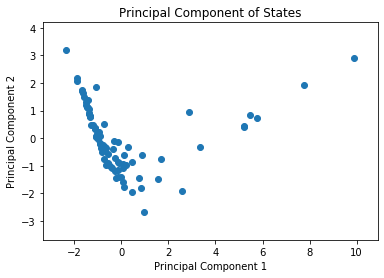

In [16]:
dat=Database[['Magnitude','Intensity (MMI / JMA)','Fatalities','Injuries','displaced','Impact value (D)','buildings damaged','buildings destroyed']].dropna()
sca=scale(dat)
pca_model = PCA()
X_PCA = pca_model.fit_transform(sca)
fig, ax = plt.subplots()
ax.set_xlim(X_PCA[:,0].min()-1,X_PCA[:,0].max()+1)
ax.set_ylim(X_PCA[:,1].min()-1,X_PCA[:,1].max()+1)
plt.scatter(X_PCA[:,0],X_PCA[:,1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Principal Component of States')

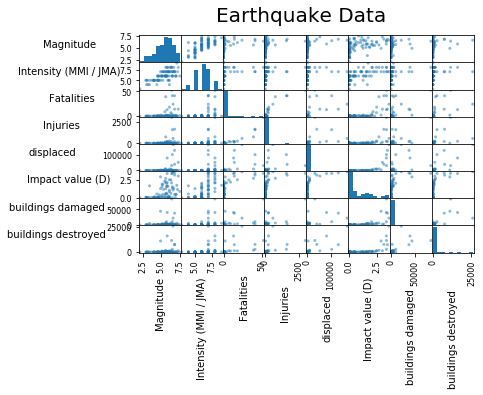

In [17]:
axs=pd.plotting.scatter_matrix(dat)
plt.suptitle('Earthquake Data', size=20)
n = len(dat.columns)
for x in range(n):
    for y in range(n):
        # to get the axis of subplots
        ax = axs[x, y]
        # to make x axis name vertical  
        ax.xaxis.label.set_rotation(90)
        # to make y axis name horizontal 
        ax.yaxis.label.set_rotation(0)
        # to make sure y axis names are outside the plot area
        ax.yaxis.labelpad = 50

In [18]:
var_ratio = pca_model.explained_variance_ratio_
print(var_ratio)

[0.57296607 0.17127359 0.10469433 0.06114026 0.04497316 0.02407714
 0.0156102  0.00526525]


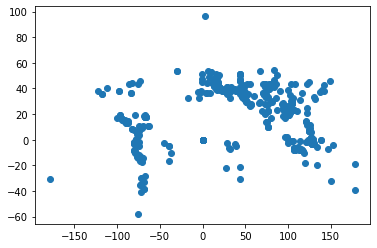

In [19]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(["#e41a1c","#984ea3","#a65628","#377eb8"])
plt.scatter(Database['Long'],Database['Lat'])

C:\Users\paulm\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


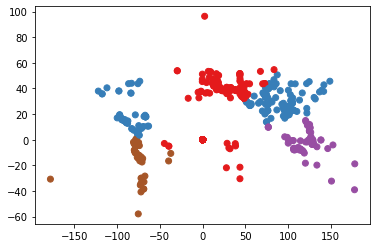

In [20]:
quac=earthquake_data[['Lat','Long']]
scal=scale(quac)
y_pred = KMeans(n_clusters=6,n_init=50).fit_predict(scal)
quac['grouping']=y_pred
plt.scatter(quac['Long'],quac['Lat'],c=y_pred,cmap=cmap)

## Groupings for countries

C:\Users\paulm\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


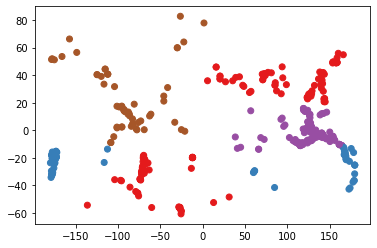

In [21]:
quac=Current[['lattitude','longitude']]
scal=scale(quac)
y_pred = KMeans(n_clusters=7,n_init=50).fit_predict(scal)
quac['grouping']=y_pred
plt.scatter(quac['longitude'],quac['lattitude'],c=y_pred,cmap=cmap)

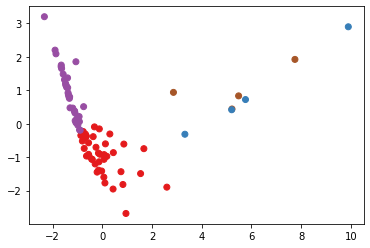

In [22]:
y_pred = KMeans(n_clusters=4).fit_predict(sca)
dat['grouping']=y_pred
plt.scatter(X_PCA[:,0],X_PCA[:,1],c=y_pred,cmap=cmap)

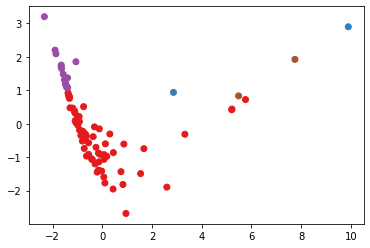

In [23]:
agg_cluster_model = AgglomerativeClustering(linkage='complete', affinity='euclidean', n_clusters=7)
y_pred1 = agg_cluster_model.fit_predict(sca)
dat['grouping1']=y_pred1
plt.scatter(X_PCA[:,0],X_PCA[:,1],c=y_pred1,cmap=cmap)

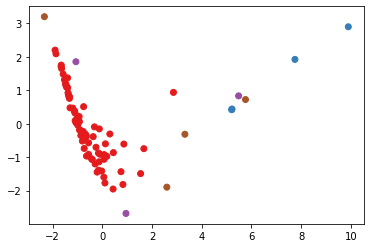

In [24]:
db_model = DBSCAN(eps=1, min_samples=1).fit(sca)
y_pred2 = db_model.fit_predict(sca)
dat['grouping2']=y_pred2
plt.scatter(X_PCA[:,0],X_PCA[:,1],c=y_pred2,cmap=cmap)

In [25]:
stamp=earthquake_data[(3<= earthquake_data['Magnitude'])&(earthquake_data['Magnitude']<4)]
(len(stamp.groupby(['Country']).get_group('USA'))/len(earthquake_data.groupby(['Country']).get_group('USA')))*100

18.75

In [91]:
def probability(c):
    its=[2,3,4,5,6,7,8,9,10]
    m=[]
    for i in range(len(its)-1):
        stamp=earthquake_data[(its[i]<= earthquake_data['Magnitude'])&(earthquake_data['Magnitude']<its[i+1])]
        try:
            t=len(stamp.groupby(['Country']).get_group(c))/len(earthquake_data.groupby(['Country']).get_group(c))*100
        except:
            t='nana'
        m.append(t)
    return(m)

def biggets(c):
    stamp=earthquake_data.groupby(['Country']).get_group(c)
    smoke=stamp['Magnitude'].idxmax()
    big=earthquake_data.iloc[[smoke]]
    return(big)


def frequent(c):
    stamp=earthquake_data.groupby(['Country']).get_group(c)
    smoke=stamp['Region'].value_counts().max()
    con=stamp['Region'].mode()[0]
    return(con,smoke)



Puerto Rico 9


In [92]:
html="""<h4><b>Earquakes Info</b></h4>
<b>Location: </b>%s
<br>
<b>Magnitude: </b>%s
<br>"""

html2="""
<h4><b>Earthquakes by Country</b></h4>
<b>Country: </b>%s
<br>
<ul style="list-style-type:none;">
  <li><b>Coffee</b></li> %s
  <li><b>Tea</b></li> %s
  <li><b>Milk</b></li> %s
</ul>
"""

In [93]:
print(html)

<h4><b>Earquakes Info</b></h4>
<b>country: </b>%s
<br>
<b>Magnitude: </b>%s
<br>
